Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from datetime import date

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
from sklearn.metrics import mean_absolute_error

In [8]:
import numpy as np

In [9]:
import lightgbm as lgb

In [10]:
from lightgbm import LGBMRegressor

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [12]:
from catboost import CatBoostRegressor

In [13]:
import matplotlib.pyplot as plt

In [14]:
import warnings
warnings.filterwarnings('ignore')

# 1. Подготовка данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км) 
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [15]:
cars = pd.read_csv('/datasets/autos.csv')

In [16]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [17]:
cars.head(40)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Видим некорректные типы данных. Заменяем на datetime:
- в DateCreated 
- в LastSeen.

DateCrawled — дата скачивания анкеты из базы можно вообще удалить, не несет смысла.

In [18]:
for column in cars[['DateCreated', 'LastSeen']]:
    cars[column] = pd.to_datetime(cars[column], format='%Y-%m-%d %H:%M:%S')

In [19]:
cars = cars.drop(['DateCrawled'], axis = 1)

In [20]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [21]:
print(cars['RegistrationYear'].sort_values())

244092    1000
91869     1000
143621    1000
55605     1000
164397    1000
          ... 
167937    9999
217111    9999
149151    9999
326725    9999
224832    9999
Name: RegistrationYear, Length: 354369, dtype: int64


Видим некорректные года, как с меньшей, так и с большей стороны. Удаляем хвосты.

In [22]:
today = date.today()

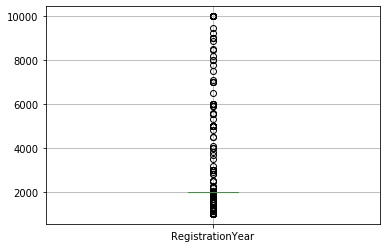

In [23]:
# распределение по году регистрации
cars.boxplot(column='RegistrationYear')

In [24]:
# IQR возьмем 3, чтобы не потерять лишнее
cars =  cars.loc[(cars['RegistrationYear'] <= today.year) & (cars['RegistrationYear'] > 1970)] 

In [25]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,352593.000000,352593.000000,352593.000000,352593.000000,352593.000000,352593.0,352593.000000
mean,4407.964027,2003.281398,110.279733,128508.436072,5.725794,0.0,50520.056153
std,4503.571855,6.890340,187.916640,37564.481445,3.723883,0.0,25774.235373
min,0.000000,1971.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49419.000000
75%,6390.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Заполняем пропуски

In [26]:
cars['Model'] = cars['Model'].fillna(cars.groupby(['Brand', 'Power'])['Model'].transform('first'))
# группируем по бренду, мощности и берем аналог модели

In [27]:
cars['VehicleType'] = cars['VehicleType'].fillna(cars.groupby('Model')['VehicleType'].transform('first'))
#заполняем тип автомобильного кузова на кузов аналогичной модели

In [28]:
cars['Gearbox'] = cars['Gearbox'].fillna(cars.groupby(['Model', 'Price'])['Gearbox'].transform('first'))
# группируем по модели и цене и берем аналог типа коробки передач

In [29]:
cars['FuelType'] = cars['FuelType'].fillna(cars.groupby(['Model', 'Price'])['FuelType'].transform('first'))
# группируем по модели и цене и берем аналог типа топлива

In [30]:
cars['NotRepaired'] = cars['NotRepaired'].fillna(cars.groupby(['Model', 'RegistrationYear'])['NotRepaired'].transform('first'))
# группируем по модели и году производства, предполагая возможный ремонт

In [31]:
#cars.head(40)

In [32]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352593 entries, 0 to 354368
Data columns (total 15 columns):
Price                352593 non-null int64
VehicleType          351638 non-null object
RegistrationYear     352593 non-null int64
Gearbox              350240 non-null object
Power                352593 non-null int64
Model                349476 non-null object
Kilometer            352593 non-null int64
RegistrationMonth    352593 non-null int64
FuelType             349488 non-null object
Brand                352593 non-null object
NotRepaired          350849 non-null object
DateCreated          352593 non-null datetime64[ns]
NumberOfPictures     352593 non-null int64
PostalCode           352593 non-null int64
LastSeen             352593 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(7), object(6)
memory usage: 43.0+ MB


In [33]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,352593.000000,352593.000000,352593.000000,352593.000000,352593.000000,352593.0,352593.000000
mean,4407.964027,2003.281398,110.279733,128508.436072,5.725794,0.0,50520.056153
std,4503.571855,6.890340,187.916640,37564.481445,3.723883,0.0,25774.235373
min,0.000000,1971.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49419.000000
75%,6390.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В NumberOfPictures у на с везде 0, можно удалить столбец.

In [34]:
cars = cars.drop(['NumberOfPictures'], axis = 1)

In [35]:
cars['PostalCode'] = cars['PostalCode'].astype('str')

In [36]:
#добавляем столбец с возрастом авто
today = date.today()
cars['age'] = round(today.year - cars['RegistrationYear'] + cars['RegistrationMonth']/12)
cars['age'] =cars['age'].astype('int')

In [37]:
#добавляем столбец с продолжительностью нахождения в базе (очень долго - плохо, цена некорректтная, должно влиять на оценку)
cars['duration'] = (cars['LastSeen'] - cars['DateCreated']).dt.days

In [38]:
cars = cars.dropna()

In [39]:
cars.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,age,duration
0,480,small,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24,70435,2016-04-07 03:16:57,27,14
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,9,14
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,2016-03-14,90480,2016-04-05 12:47:46,17,22
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,20,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,13,6


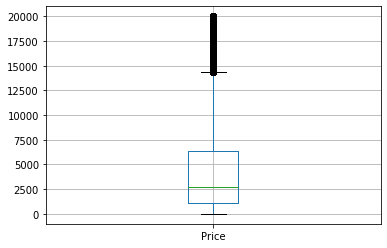

In [40]:
cars.boxplot(column='Price') # график «ящик с усами» для цены 

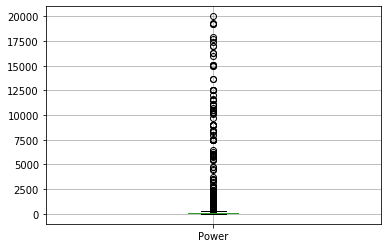

In [41]:
cars.boxplot(column='Power')# график «ящик с усами» для мощности 
plt.show()

In [42]:
cars.describe()


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,age,duration
count,346208.000000,346208.000000,346208.000000,346208.000000,346208.000000,346208.000000,346208.000000
mean,4416.784606,2003.315825,110.420785,128955.338987,5.755321,17.149763,8.658425
std,4496.184801,6.786469,180.495942,36988.018602,3.711213,6.795244,8.521721
min,0.000000,1971.000000,0.000000,5000.000000,0.000000,1.000000,0.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,13.000000,2.000000
50%,2750.000000,2003.000000,105.000000,150000.000000,6.000000,17.000000,6.000000
75%,6399.000000,2008.000000,143.000000,150000.000000,9.000000,22.000000,13.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,50.000000,384.000000


По цене: отсечем явно выбивающиеся значения (IQR возьмем 1,5). Получается, отсекаем цифры больше 14350. Кто-то явно завышал цену.

По мощности: отсечем явно выбивающиеся значения (IQR возьмем 1,5). Получается, отсекаем цифры больше 254.

In [43]:
cars = cars[cars['Price'] < 14350]

In [44]:
cars = cars[cars['Power'] < 255]

In [45]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,age,duration
count,322922.000000,322922.000000,322922.000000,322922.000000,322922.000000,322922.000000,322922.000000
mean,3656.039397,2002.981116,100.493101,130851.382067,5.719635,17.481383,8.493782
std,3414.859933,6.708303,54.848462,35398.853979,3.724890,6.718353,8.461124
min,0.000000,1971.000000,0.000000,5000.000000,0.000000,1.000000,0.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000,14.000000,2.000000
50%,2499.000000,2003.000000,101.000000,150000.000000,6.000000,18.000000,6.000000
75%,5490.000000,2007.000000,140.000000,150000.000000,9.000000,22.000000,13.000000
max,14349.000000,2019.000000,254.000000,150000.000000,12.000000,50.000000,384.000000


In [46]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322922 entries, 0 to 354368
Data columns (total 16 columns):
Price                322922 non-null int64
VehicleType          322922 non-null object
RegistrationYear     322922 non-null int64
Gearbox              322922 non-null object
Power                322922 non-null int64
Model                322922 non-null object
Kilometer            322922 non-null int64
RegistrationMonth    322922 non-null int64
FuelType             322922 non-null object
Brand                322922 non-null object
NotRepaired          322922 non-null object
DateCreated          322922 non-null datetime64[ns]
PostalCode           322922 non-null object
LastSeen             322922 non-null datetime64[ns]
age                  322922 non-null int64
duration             322922 non-null int64
dtypes: datetime64[ns](2), int64(7), object(7)
memory usage: 41.9+ MB


# 2. Обучение моделей

In [47]:
catfeatures = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

In [48]:
#le = LabelEncoder()
#cars[catfeatures] = cars[catfeatures].apply(lambda col: le.fit_transform(col))

In [49]:
#cars[catfeatures] = pd.get_dummies(cars[catfeatures], drop_first=True)

In [50]:
for c in catfeatures:
    cars[c] = cars[c].astype('category')

In [51]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322922 entries, 0 to 354368
Data columns (total 16 columns):
Price                322922 non-null int64
VehicleType          322922 non-null category
RegistrationYear     322922 non-null int64
Gearbox              322922 non-null category
Power                322922 non-null int64
Model                322922 non-null category
Kilometer            322922 non-null int64
RegistrationMonth    322922 non-null int64
FuelType             322922 non-null category
Brand                322922 non-null category
NotRepaired          322922 non-null category
DateCreated          322922 non-null datetime64[ns]
PostalCode           322922 non-null category
LastSeen             322922 non-null datetime64[ns]
age                  322922 non-null int64
duration             322922 non-null int64
dtypes: category(7), datetime64[ns](2), int64(7)
memory usage: 27.8 MB


In [52]:
cars.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,age,duration
0,480,small,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24,70435,2016-04-07 03:16:57,27,14
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,2016-03-14,90480,2016-04-05 12:47:46,17,22
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,20,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,13,6
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07,26,2


In [53]:
target = cars['Price']
features = cars.drop(columns=['Price', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1)

In [54]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)
# делим выборку на обучающую, валидационную и тестовую в соотношении 3:1:1.

In [55]:
numeric = ['Power', 'Kilometer', 'age', 'duration']
sc=StandardScaler()
features_train[numeric] = sc.fit_transform(features_train[numeric])
features_valid[numeric] = sc.transform(features_valid[numeric])
features_test[numeric] = sc.transform(features_test[numeric])

In [56]:
#cars.head()

In [57]:
#model = CatBoostRegressor()
#model.fit(features_train, target_train, cat_features=catfeatures)
#predicted_valid = model.predict(features_valid)
#print('The rmse of prediction is:', mean_squared_error(target_valid, predicted_valid))

In [58]:
#lgb_train = lgb.Dataset(features_train, target_train)

In [59]:
#params = {
# 'task': 'train'
# , 'boosting_type': 'gbdt'
# , 'objective': 'regression' 
# , 'metric': 'rmsle'
# , 'verbose': -1}

In [60]:
#gbm = lgb.train(params, lgb_train)

In [61]:
#predicted_valid = gbm.predict(features_valid)

In [62]:
#print('The rmse of prediction is:', mean_squared_error(target_valid, predicted_valid))

Точные цифры по скорости могут не воспроизводится всегда одинаково, т.к. при использовании меджик функции для оценки времени точные цифры могут варьировать.

In [63]:
%%time 
#Время выполнения ячейки кода Jupyter Notebook для обучения модели с параметрами по умолчанию
model = LGBMRegressor()
model.fit(features_train, target_train, categorical_feature=catfeatures)

CPU times: user 28.3 s, sys: 136 ms, total: 28.4 s
Wall time: 30.5 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [64]:
%%time
#Время выполнения ячейки кода Jupyter Notebook для предсказания модели с параметрами по умолчанию
predicted_valid = model.predict(features_valid)
predicted_test = model.predict(features_test)
print('The rmse of prediction valid is:', mean_squared_error(target_valid, predicted_valid)**0.5)
print('The rmse of prediction test is:', mean_squared_error(target_test, predicted_test)**0.5)

The rmse of prediction valid is: 1458.0412142786213
The rmse of prediction test is: 1473.3731617019735
CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 2.79 s


Получаем слудующие скорости для настроек по умолчанию:
    - 21.5 s для обучения
    - 2.6 s для предсказания.
Основное время занимает обучение модели, его будем уменьшать.

Значения предсказаний на тесте близки значению предсказаний на валидационной.

Проведем настройку модели градиентного бустинга, изменяя два-три параметра, для увеличения точности и скорости.

## 3. Анализ моделей

max_depth = -3 :1458.0412142786213 1473.3731617019735
max_depth = -2 :1458.0412142786213 1473.3731617019735
max_depth = -1 :1458.0412142786213 1473.3731617019735
max_depth = 0 :1458.0412142786213 1473.3731617019735
max_depth = 1 :1964.5900995194736 1984.884958716169
max_depth = 2 :1672.1270309923111 1688.459854955382
max_depth = 3 :1567.4449684528731 1581.409148199392
max_depth = 4 :1515.4581014536898 1526.2288799367577
max_depth = 5 :1477.6271264766478 1489.9534565451154
max_depth = 6 :1467.4142483375394 1478.403049035919


Text(0.5, 0, 'max depth')

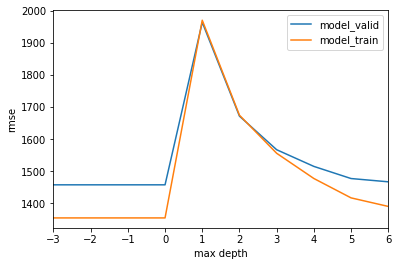

In [65]:
model_train = {}
model_valid = {}
for depth in range(-3, 7, 1):
    model = LGBMRegressor(max_depth=depth)
    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)
    predicted_test = model.predict(features_test)
    
    model_train[depth] = mean_squared_error(target_train, predicted_train)**0.5 
    model_valid[depth] = mean_squared_error(target_valid, predicted_valid)**0.5
    print('max_depth =', depth, ':', end='')
    print( mean_squared_error(target_valid, predicted_valid)**0.5, mean_squared_error(target_test, predicted_test)**0.5)

model_valid = pd.Series(model_valid)
model_train = pd.Series(model_train)
model_rmse = pd.DataFrame({'model_valid': model_valid, 'model_train': model_train})
model_rmse.plot()
plt.ylabel('rmse')
plt.xlabel('max depth')

Получаем оптимальное значение max depth=3.

In [66]:
%%time 
model = LGBMRegressor(max_depth=3)
model.fit(features_train, target_train, categorical_feature=catfeatures)

CPU times: user 1min 41s, sys: 372 ms, total: 1min 42s
Wall time: 1min 50s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Самое лучшее значение метрики max_depth=3 имеет rmse=1567 , время обучения существенно улучшилось до 7.23.

In [67]:
# исходя из рекомендации num_leaves = 2^(max_depth) подбираем num_leaves
for leaves in range(2, 9, 1):
    model = LGBMRegressor(num_leaves=leaves, max_depth=3)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('leaves =', leaves, ':', end='')
    print( mean_squared_error(target_valid, predicted_valid)**0.5)

leaves = 2 :1964.5900995194736
leaves = 3 :1690.719663106488
leaves = 4 :1631.180459486469
leaves = 5 :1593.3608821116618
leaves = 6 :1580.130295611349
leaves = 7 :1579.0481966369096
leaves = 8 :1567.4449684528731


Метрику num_leaves выбираем 8.

In [68]:
%%time 
model = LGBMRegressor(num_leaves=8, max_depth=3, bagging_fraction=0.8)
model.fit(features_train, target_train, categorical_feature=catfeatures)

CPU times: user 7.36 s, sys: 48 ms, total: 7.41 s
Wall time: 7.58 s


LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
              max_depth=3, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=8,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

Скорость еще уменьшилась до 7.73.

In [69]:
%%time 
#установим bagging_fraction 0.2
model = LGBMRegressor(num_leaves=8, max_depth=3, bagging_fraction=0.2)
model.fit(features_train, target_train, categorical_feature=catfeatures)

CPU times: user 7.84 s, sys: 48 ms, total: 7.89 s
Wall time: 7.99 s


LGBMRegressor(bagging_fraction=0.2, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
              max_depth=3, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=8,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

Скорость еще уменьшилась до 6.97.

In [70]:
%%time 
model = LGBMRegressor(num_leaves=8, max_depth=3, bagging_fraction=0.2)
model.fit(features_train, target_train, categorical_feature=catfeatures)
predicted_valid = model.predict(features_valid)
predicted_test = model.predict(features_test)

CPU times: user 9.04 s, sys: 36 ms, total: 9.08 s
Wall time: 9.2 s


In [71]:
print('The rmse of prediction valid is:', mean_squared_error(target_valid, predicted_valid)**0.5)
print('The rmse of prediction test is:', mean_squared_error(target_test, predicted_test)**0.5)

The rmse of prediction valid is: 1567.4449684528731
The rmse of prediction test is: 1581.409148199392


## Выводы

Произведен подбор параметров по умолчанию, подобраны параметры для оптимизации модели:
    - num_leaves=8, 
    - max_depth=3, 
    - bagging_fraction=0.2
    
Это позволило также увеличить скорость обучения с предсказанием примерно в 2,75 раз (тут не приводятся точные цифры по скорости, т.к. при использовании меджик функции для оценки времени точные цифры варьировали).
